<a href="https://colab.research.google.com/github/garry-cotton/CS909/blob/master/2023/A1/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1: Exploring Data

First, we bring in the dataset from a forked Github repo and look at the number of observations present in the test and training sets.

In [27]:
# Get files
!wget -q -O Xtrain.csv https://raw.githubusercontent.com/garry-cotton/CS909/master/2023/A1/Xtrain.csv
!wget -q -O Ytrain.csv https://raw.githubusercontent.com/garry-cotton/CS909/master/2023/A1/Ytrain.csv
!wget -q -O Xtest.csv https://raw.githubusercontent.com/garry-cotton/CS909/master/2023/A1/Xtest.csv

In [28]:
# Library imports
import numpy as np
import pandas as pd
from numpy.random import rand
import os
import matplotlib.pyplot as plt

In [29]:
# Data load
X_train = np.loadtxt("Xtrain.csv")
Y_train = np.loadtxt("Ytrain.csv")
X_test = np.loadtxt("Xtest.csv")

# Dataset sizes
n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_positive = np.sum(Y_train == 1)
n_negative = n_train - n_positive

print("Number of training examples:", n_train)
print("Number of positive training labels:", n_positive)
print("Number of negative training labels:", n_negative)
print("Number of test examples:", n_test)

Number of training examples: 3000
Number of positive training labels: 611
Number of negative training labels: 2389
Number of test examples: 3000


i) There are 3000 training and test samples. The training labels are highly imbalanced with only 611 positive labels to 2389 negative.

<Figure size 432x288 with 0 Axes>

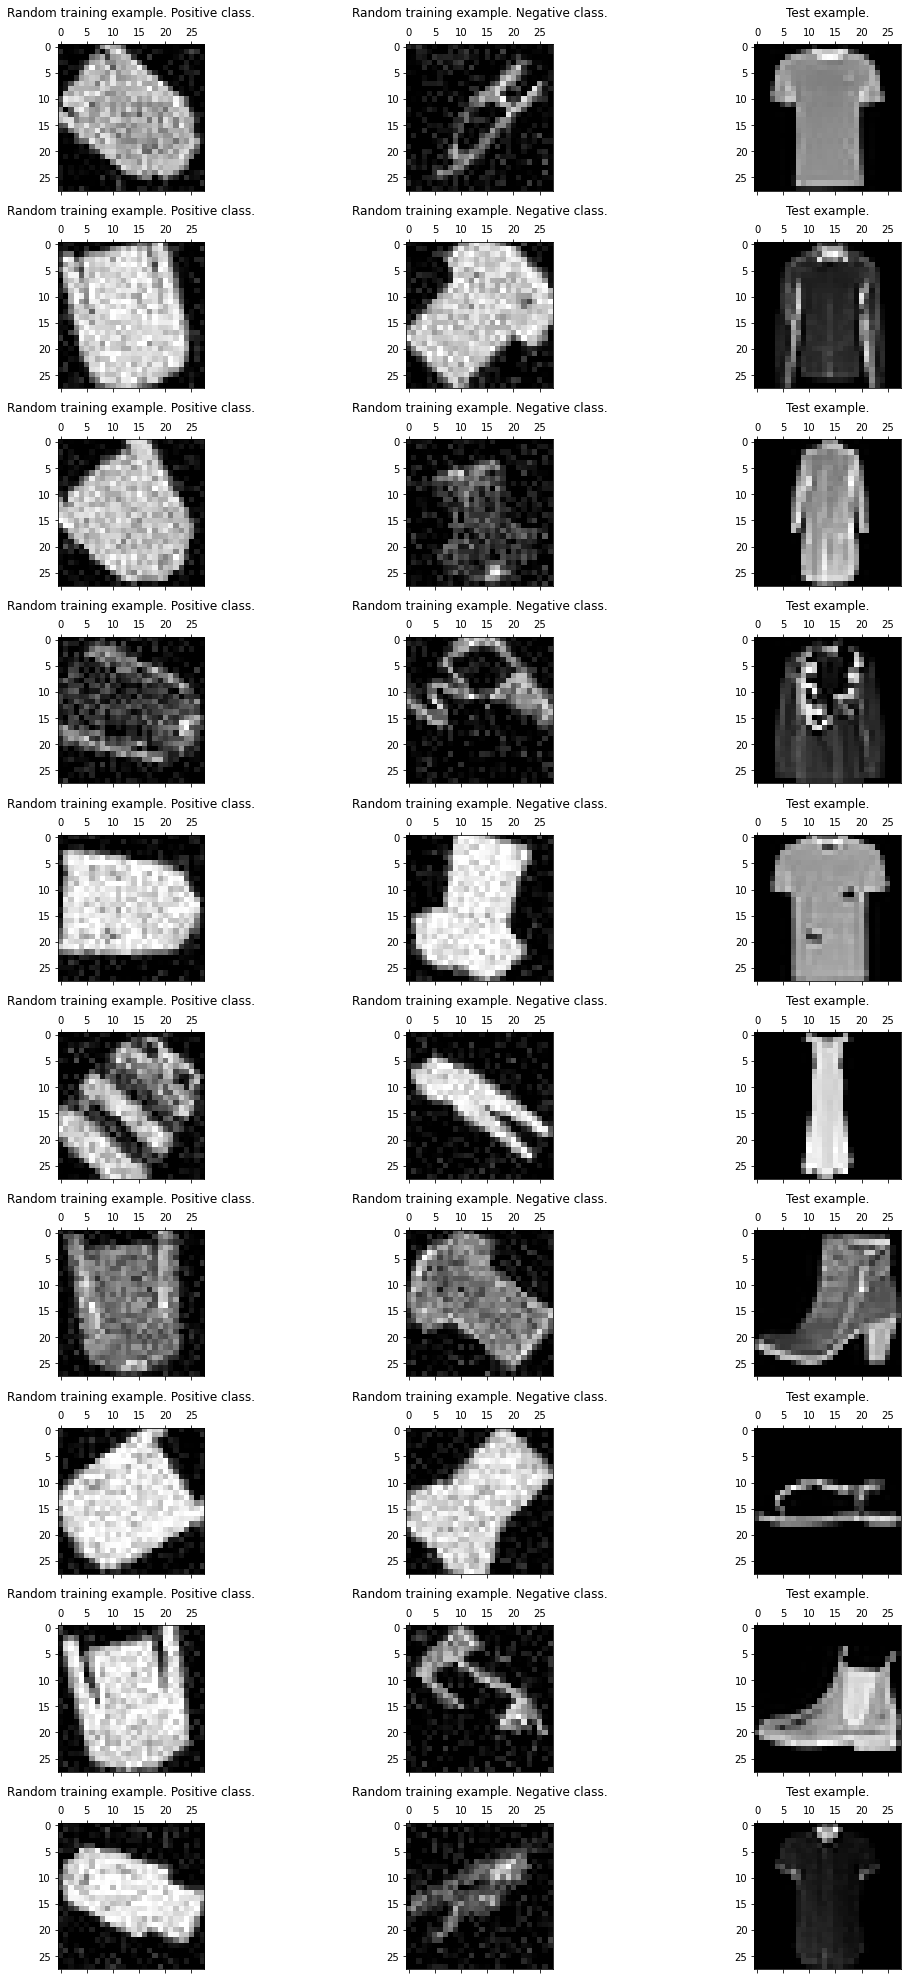

In [35]:
X_train = X_train.reshape(n_train, 28, 28)
X_test = X_test.reshape(n_test, 28, 28)
positives = Y_train == 1
X_train_positive = X_train[positives]
X_train_negative = X_train[np.logical_not(positives)]

plt.gray()
fig, axs = plt.subplots(10, 3, figsize=(30,30))
rand_train_positive = np.round(rand(10, 1) * n_positive, 0).astype(int)
rand_train_negative = np.round(rand(10, 1) * n_negative, 0).astype(int)
rand_test = np.round(rand(10, 1) * n_test, 0).astype(int)

for i in range(10):
  train_positive_idx = rand_train_positive[i].item()
  train_negative_idx = rand_train_negative[i].item()
  test_idx = rand_test[i].item()

  axs[i, 0].matshow(X_train_positive[train_positive_idx])
  axs[i, 0].set_title(f"Random training example. Positive class.", pad=20)
  axs[i, 1].matshow(X_train_negative[train_negative_idx])
  axs[i, 1].set_title(f"Random training example. Negative class.", pad=20)
  axs[i, 2].matshow(X_test[test_idx])
  axs[i, 2].set_title(f"Test example.", pad=20)

fig.tight_layout(rect=[0, 0.03, 0.6, 0.95])

ii) It is clear the data are small pictures of articles of clothing. It appears the positive label relates to long sleeved tops or jackets and the negative label is assigned to all other pieces of clothing.

It also appears that the training data is more noisy than the test data. In particular, from a purely visual perspective it makes the images difficult to interpret for darker coloured items. This could cause difficulties in classification if the model fits to some of this noise.

iii) We have significantly imbalanced data with only approximately 20% of the training data of the positive class. Therefore, neither the accuracy nor AUCROC would be a good choice of performance metric as one of their key assumptions is not met.

AUCPR would be an effective metric as it does not suffer from the same limitation. The choice of threshold depends on the purpose of the model and how the classification exercise is prioritized. We have to weigh out the costs of misclassifying positive or negative examples. If the greatest priority is correctly classifying jackets with the acceptance of falsely including some other articles of clothing, we would prioritise recall. If, however, we seek to discriminate more harshly on whether a new case is a jcket we would tune the model for precision.

In addition to AUCPR, the $F_β$ score can also facilitate this requirement, summarizing the effectiveness of the model in a single score and allowing for weighting based on the respective priorities of precision and recall.


iv) Consider a classifier with probability $p_+$ of classifying an example as positive randomly. The classifier is applied to a dataset of $n$ examples with $n_+$ positive examples.

Then we have

$
\begin{align}
  & \quad TP = n_+p_+ \\ 
  & \quad TN = (n - n_+)(1 - p_+)
\end{align}
$

Hence 

$
\quad accuracy = \frac{TP + TN}{n} = \frac{n_+p_+ + (n - n_+)(1 - p_+)}{n}
$

In our concrete case we have $n = 3000 \text{ and } n_+ = 611$. If we assume the probability of selecting each label is equal then $p_+ = \frac{1}{2}$ and hence

$
\quad accuracy = \frac{611 \times \frac{1}{2} + 2389 \times \frac{1}{2}}{3000} = \frac{\frac{1}{2} \times 3000}{3000} = \frac{1}{2} = 50\%
$

So in this case the data imbalance has no effect on the accuracy. This is due to the fact the weighting of positive and negative examples is equal. If we trained a classifier to randomly classify more negative examples, say with probability $p_+ = 0.1 \implies p_- = (1 - p_+) = 0.9$ then the accuracy of the model would greatly increase to roughly $74\%$.

We could take this measure to the extreme by classifying all examples as negative and artificially obtain an accuracy of roughly $80\%$. The code below constructs a table of accuracy scores for a random classifier to support these assertions.

In [40]:
def accuracy(n, n_positive, threshold):
  tp = n_positive * threshold
  tn = (n - n_positive) * (1 - threshold)
  return (tp + tn)/n

accuracies = pd.DataFrame(index = np.arange(0, 101), 
                          columns = ["threshold", "accuracy"])

for i, thresh in enumerate([x/100 for x in range(101)]):
  acc = accuracy(n_train, n_positive, thresh)  
  accuracies.iloc[i] = (thresh, acc)

accuracies

v) We suspect the AUC-ROC for a random classifier will be $0.5$ regardless of data imbalance. To show this explicitly, we obtain the area under the curve by integrating the ROC curve across all possible TPR and FPR values, which with random classification we have 

$
\begin{align}
\quad TPR = \frac{TP}{n_+} = \frac{n_+p_+}{n_+} = p_+, \
  FPR = \frac{FP}{(1-n_+)} = \frac{(1-n_+)p_+}{(1-n_+)} = p_+
\end{align}
$.

Hence 

$
\begin{align}
\quad AUCROC 
&= \int d(TPR, FPR) 
  = \int_{p_+ \in [0,1], p_+' \in [0, p_+]} d(p_+, p_+') \\
&= \int_{p_+=0}^1 \left( \int_{p_+'=0}^{p_+} dp_+' \right) dp_+
  = \int_0^1 p_+ dp_+
  = \left. \frac{p_+^2}{2} \right|_0^1 = \frac{1}{2}
\end{align}
$

So a random classifier will give us an AUC-ROC score of $0.5$ independent of data imbalance.

The case for AUC-PR is different. We integrate across all possible values of 

$
\begin{align}
\quad Recall = TPR = p_+, \ 
  Precision = \frac{n_+p_+}{np_+} = \frac{n_+}{n}
\end{align}
$

Hence

$
\begin{align}
\quad AUCPR 
  = \int d(Recall, Precision) 
  = \frac{n_+}{n} \int_{p_+=0}^1 dp_+
  = \frac{n_+}{n}
  = Prevalence
\end{align}
$